# Map plant traits using automated machine learning (autoML)

This section is about supervised data analysis (or modelling). Supervised means that we have a clear idea what we want to reveal from the data (in contrast to unsupervised methods, such as a PCA analysis, where we let the statistics reveal what is in the data). We can, for instance, use climate data to predict the global spatial distribution of certain plant properties (also called plant traits). The idea is that plant traits, such as the plant height or nitrogen are determined by climate (e.g. the warmer and the more water we have, the larger plants will grow). What we need for such a global modelling exercise is:
1) the climate data
2) a model to predict the plant trait from the satellite data (a 'translator', that translates reflectance values into traits)
3) Reference measurements, which we can use as 'examples' to show the model what reflectance values correspond to what trait values.

The cliamte data and the trait data we have (climate data from WorldClim and trait data from sPlot). However, we do not have a model yet. Let´s go for machine learning because machine learning is capable of complex systems composed of many variables and non-linear relationships. At first, we have to train such a machine learning model, for which we can use several algorithms. There exist many algorithms for such tasks (e.g. random forest, XGBoost, Support Vector Machines, Guassian Process Models, etc...) and there exists many ways how we can adjust the settings of such a method (often models come with a bunch of options). And this is often the problem: How to decide which algorithm and settings to use to find the best model?

A promising answer to these problems is automated machine learning (autoML). What is autoML? The idea of automated machine learning is that for a given probelm a pipeline will test which model algorithms unter which parameters will result in the best performance. Thus, the idea of AutoML is to automatically find the best model with the best settings. autoML is curretnly quite hyped - particularly for the applied sciences, where we do not want to go too deep into technical details. Well, enough said, lets dive into autoML analysis.

We wil use AutoGluon, which is a framework for AutoML that is very comprehensive and nicely documented:

https://auto.gluon.ai/stable/tutorials/tabular/tabular-quick-start.html

https://auto.gluon.ai/stable/tutorials/

## Assignments
* Run the code below to explore the capabilties of autoML
* How well can you predicting other plant traits than plant height?
    * Explore 5-10 traits.  
* Does the model perormance for predicting the response (y) increase when you add more predictors (x)?
    * add vertial optical depth (VODCA), MODIS reflectance (e.g. vegetation indicies), or soil information (SoildGrids).
    * which variables are more important? Summarize the variable importance by dataset (e.g. MODIS, VOCCA, etc...).
* Compare the predictions with the biome data ("data/biomes").
    * Do the predictions make sense?
* Test some ensemble predictions.The idea of ensembles is that "more eyes (or models) see more than one".
    * You can either manually select different models or even train a weighted ensemble. https://auto.gluon.ai/stable/tutorials/tabular/tabular-indepth.html

## Load packages, etc.

In [1]:
# Consider to create a new environment for this notebook (e.g. msc_remote_sens_2024_ml), given that the autoML libraries may cause package conflicts

# mamba install autogluon pandas rioxarray glob matplotlib ipykernel numpy -c conda-forge
import rioxarray
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
import geopandas as gpd
import rasterio

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load and prepare the predictors (x, raster data)
This is the data we will use to extrapolate our target variable (response)

In [3]:
worldclim_files = glob.glob('data/earth_obseration_products/worldclim_res/**/*.tif', recursive=True)
worldclim_files

['data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_1.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_12.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_13-14.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_15.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_4.tif',
 'data/earth_obseration_products/worldclim_res\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_7.tif']

In [4]:
# open all files 
worldclim = {os.path.basename(rf).split('deg_', 1)[-1].split('.tif', 1)[0]: rioxarray.open_rasterio(rf) for rf in worldclim_files}
worldclim.keys()

dict_keys(['bio_1', 'bio_12', 'bio_13-14', 'bio_15', 'bio_4', 'bio_7'])

In [5]:
worldclim["bio_1"].rio.write_nodata(3.400000e+38, inplace=True) 

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.4e+38) has been automatically changed to (3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(


<xarray.DataArray (band: 1, y: 900, x: 1800)> Size: 6MB
[1620000 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * y            (y) float64 7kB 89.9 89.7 89.5 89.3 ... -89.3 -89.5 -89.7 -89.9
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  31.387500762939
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -54.770832061768
    STATISTICS_STDDEV:   nan
    _FillValue:          3.4e+38
    scale_factor:        1.0
    add_offset:          0.0

In [6]:
# set all no data and inf vlaues to nan
worldclim = {key: raster.where((raster > -3.400000e+37) & (raster < 3.400000e+37) & (raster != -np.inf), other=np.nan) for key, raster in worldclim.items()}

## Load and prepare the response variables (y, point data)
This is the data we want to extrapolate (also called reference or labels)

In [7]:

# This dataset was added recently - please download it from https://drive.google.com/file/d/1-PNVuR6eblGAjlkyPwAwH-pmjZDwmkEa/view?usp=sharing
splot = pd.read_csv("data/sPlotOpen_original_3474_76_Dataset/sPlotOpen_TRYgapfilled_cwm.csv")
splot.head()

,PlotObservationID,Releve_area,Latitude,Longitude,X1080,X11,X13,X138,X14,X144,...,X3114,X3120,X4,X46,X47,X50,X55,X6,X78,X95
0,16,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
1,17,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
2,18,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
3,20,NaN,62.42,-154.18,8146.559461,15.105879,457.630398,22.061955,19.508648,8.946046,...,42.395932,3.892607,0.496094,0.204036,0.299290,1.393661,5.585184,0.518140,-3.232422,90.010427
4,22,NaN,62.42,-154.18,7424.037901,15.483192,456.943897,442.804275,20.750032,11.270150,...,84.587695,4.296718,0.497012,0.216458,0.287622,1.429345,8.661573,0.480919,-3.195510,89.458775


The column names for the traits (reference, y), are not self explaining. They correspond to the trait IDs in the TRY trait database (https://www.try-db.org/de/TabDetails.php).

Let´s translate them using a dictionary:

In [8]:
def shorten_names(df):
    rename_dict = {
        'X4': 'Stem specific density (SSD)',
        'X13': 'Leaf carbon (C) per mass',
        'X14': 'Leaf nitrogen (N) per mass',
        'X15': 'Leaf phosphorus (P) per mass',
        'X47': 'Leaf dry mass per leaf fresh mass (LDMC)',
        'X26': 'Seed mass',
        'X27': 'Seed length',
        'X50': 'Leaf nitrogen (N) per area',
        'X65': 'Leaf nitrogen/phosphorus (N/P)',
        'X78': 'Leaf delta15N',
        'X163': 'Leaf fresh mass',
        'X138': 'Seeds per rep. unit',
        'X169': 'Stem conduit density',
        'X237': 'Dispersal unit length',
        'X282': 'Conduit element length',
        'X18': 'Plant Height',
        'X3113': 'Leaf Area',
        'X11': 'Specific Leaf Area (SLA)',
        'X6': 'Root rooting depth',
        'X1080': 'Root length per root dry mass',
        'X3120': 'Leaf Water content per mass',
        'X21': 'Seed diameter',
        'X46': 'Leaf thickness',
        'X55': 'Leaf dry mass per leaf',
        'X95': 'Seed germination rate',
        'X144': 'Leaf length',
        'X145': 'Leaf width',
        'X146': 'Leaf carbon/nitrogen (C/N) ratio',
        'X223': 'chromosome number',
        'X224': 'chromosome cDNA content',
        'X281': 'Stem conduit diameter',
        'X289': 'Wood fibre length'
    }

    df.rename(columns=rename_dict, inplace=True)

In [9]:
shorten_names(splot)
# check the output
splot.head()

,PlotObservationID,Releve_area,Latitude,Longitude,Root length per root dry mass,Specific Leaf Area (SLA),Leaf carbon (C) per mass,Seeds per rep. unit,Leaf nitrogen (N) per mass,Leaf length,...,X3114,Leaf Water content per mass,Stem specific density (SSD),Leaf thickness,Leaf dry mass per leaf fresh mass (LDMC),Leaf nitrogen (N) per area,Leaf dry mass per leaf,Root rooting depth,Leaf delta15N,Seed germination rate
0,16,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
1,17,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
2,18,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
3,20,NaN,62.42,-154.18,8146.559461,15.105879,457.630398,22.061955,19.508648,8.946046,...,42.395932,3.892607,0.496094,0.204036,0.299290,1.393661,5.585184,0.518140,-3.232422,90.010427
4,22,NaN,62.42,-154.18,7424.037901,15.483192,456.943897,442.804275,20.750032,11.270150,...,84.587695,4.296718,0.497012,0.216458,0.287622,1.429345,8.661573,0.480919,-3.195510,89.458775


## Combine raster data (predictors, x) with point data (response, y)
Here we will use sPlotOpen. sPlotopen is a database that curates vegetation plots (typically areas of 1 to 10000 m²), where experts measured the species composition (e.g. the % cover of different species).
Find more info at:
* https://onlinelibrary.wiley.com/doi/full/10.1111/geb.13346
* https://www.idiv.de/de/splot/splotopen.html

The sPlotOpen dataset was merged with trait data from TRY. The TRY database provides trait measurements (e.g. growth height, leaf nitrogen, rooting depth) from individual plants. Based on the plant community data from sPlotOpen (which provides relative cover for different species), we can calculate community weighted trait values (from indiviuals to communities). For this, the relative cover information of sPlotOpen is joined with the traits to calculate a weighted trait average.

In the following, we will use all sPlot locations (referene, y) to extract the climate data (predictors, x). Having the predictors and the reference data paired enables us to train a model, which we can eventually (in the last step) apply to the entire WorldClim data.

In [10]:
# convert the sPlot data frame to a GeoDataFrame using geopandas (so we can extract the predictor values for each sPlot data point)
splotgdf = gpd.GeoDataFrame(splot, geometry=gpd.points_from_xy(splot.Longitude, splot.Latitude))

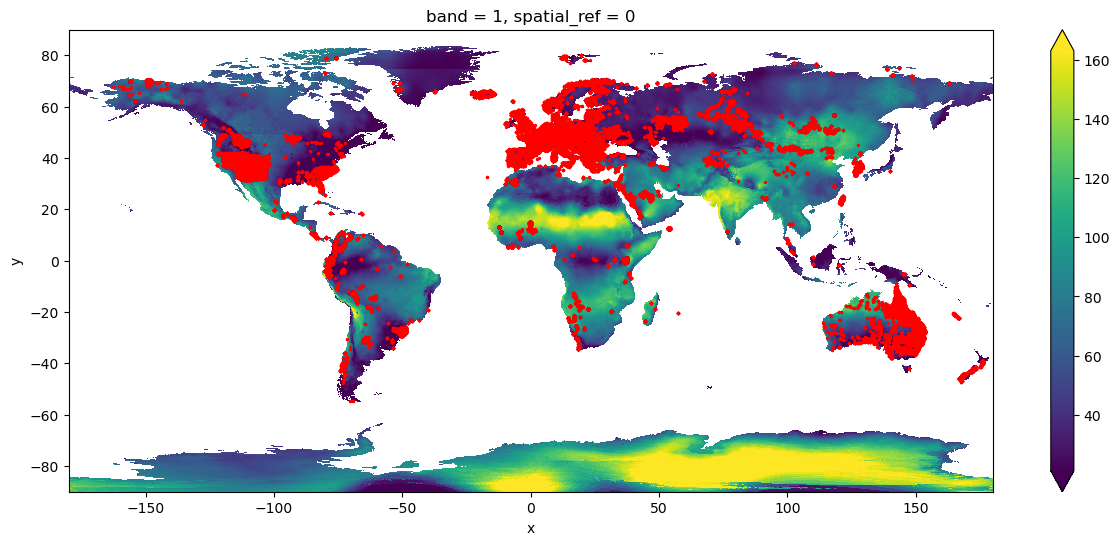

In [11]:
layer = "bio_15"

# overlay the raster with the points
plt.figure(figsize=(15, 6)) # Set the figure size
worldclim[layer].plot(vmin=worldclim[layer].quantile(0.05), vmax=worldclim[layer].quantile(0.95))
splotgdf.plot(ax=plt.gca(), color='r', markersize=2)
plt.show()

In [12]:
# extract the pixel information at each sPlotOpen plot location
predictors = pd.DataFrame()
os.makedirs("temp", exist_ok=True)

for layer in worldclim.keys():
    worldclim[layer].rio.to_raster("temp/temp_raster.tif")
    with rasterio.open("temp/temp_raster.tif") as src:
        coords = [(x.x, x.y) for x in splotgdf.geometry]
        values = list(src.sample(coords))
        values = np.asarray(values)
        predictors[layer] = pd.DataFrame(values, columns=[layer])

In [13]:
print("shape", predictors.shape)
predictors.head()

shape (94409, 6)


,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,-2.705926,416.813324,81.537781,81.587616,1237.203247,44.073334
1,-2.705926,416.813324,81.537781,81.587616,1237.203247,44.073334
2,-2.705926,416.813324,81.537781,81.587616,1237.203247,44.073334
3,-2.705926,416.813324,81.537781,81.587616,1237.203247,44.073334
4,-2.705926,416.813324,81.537781,81.587616,1237.203247,44.073334


## autoML Training
Let´s try to predict the plant height globally from sPlotOpen data using climate data.

In [14]:
label = 'Plant Height'
splot[label].describe()

count    94409.000000
mean         4.665591
std         25.787507
min          0.005096
25%          0.388243
50%          1.465298
75%          7.697927
max       6493.168562
Name: Plant Height, dtype: float64

We will use 80% of the data to train the models, while the other 20% of the data will be used to assess the model performance. It is important that the model performance is estimated with independent (unseen) data. Machine learning models are really good at learning datasets by hard and we want to avoid that it memorized the training dataset (which would result in an overoptimistic model performance estimate).

In [15]:
# merge predictors and response variable
all_data = pd.concat([splot[label], predictors], axis=1)

#split all_data in train (80%) and test (20%).
train_data = all_data.sample(frac=0.8, random_state=0)
test_data = all_data.drop(train_data.index)

In [16]:
# Lets run the default model training routine of AutoGlueon.
# This routine will test a range of models and hyperparameters...and, thus, may take a while...consider to have a coffee break :-)
predictor = TabularPredictor(label=label).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20240419_215856"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.


Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240419_215856"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:       46.19 GB / 59.72 GB (77.3%)
Disk Space Avail:   717.36 GB / 1605.68 GB (44.7%)
Train Data Rows:    75527
Train Data Columns: 6
Label Column:       Plant Height
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (6493.1685616031, 0.0050958576315789, 4.67903, 28.68628)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Problem Type:       regression
Preprocessing data ...
Using Feature Ge

Evaluate the model:

## autoML model evaluation

In [30]:
predictor.evaluate(test_data, silent=True)

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)


{'root_mean_squared_error': -3.924857721418821,
 'mean_squared_error': -15.40450813338094,
 'mean_absolute_error': -2.45272207428575,
 'r2': 0.5385097710631854,
 'pearsonr': 0.7359041447394234,
 'median_absolute_error': -1.4211195948731903}

Create predictions for the test dataset

In [31]:
y_pred = predictor.predict(test_data.drop(columns=[label]))

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)


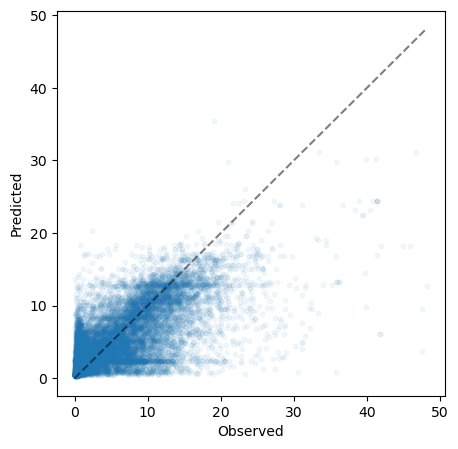

In [32]:
# scatterplot with transparency
plt.figure(figsize=(5, 5))
plt.scatter(test_data[label], y_pred, alpha=0.05, s = 10)
plt.plot([min(test_data[label]), max(test_data[label])], [min(test_data[label]), max(test_data[label])],
          color='black', alpha = 0.5, linestyle = "--")  # 1:1 line
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

This plot shows how the model performs on the test data (data that the models have never been seing. Quite good, isn't it? :-)

In [33]:
# Let´s see which of the various models was the best (quite fascinating how many different models are being tested here)
predictor.leaderboard(test_data)

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-3.924858,-3.907345,root_mean_squared_error,0.806755,0.166864,1334.543028,0.014534,0.000000,0.097630,2,True,12
1,KNeighborsUnif,-4.081158,-4.132886,root_mean_squared_error,0.152271,0.052446,4.604521,0.152271,0.052446,4.604521,1,True,1
2,KNeighborsDist,-4.082084,-4.077237,root_mean_squared_error,0.125837,0.037252,0.083325,0.125837,0.037252,0.083325,1,True,2
3,NeuralNetTorch,-4.410160,-4.305372,root_mean_squared_error,0.341105,0.048946,1158.299165,0.341105,0.048946,1158.299165,1,True,10
4,NeuralNetFastAI,-4.566731,-4.474935,root_mean_squared_error,0.300730,0.080666,175.337383,0.300730,0.080666,175.337383,1,True,8
5,LightGBMXT,-4.838619,-4.848138,root_mean_squared_error,0.017200,0.000000,1.008547,0.017200,0.000000,1.008547,1,True,3
6,LightGBMLarge,-5.621464,-5.567774,root_mean_squared_error,0.020915,0.000000,0.436670,0.020915,0.000000,0.436670,1,True,11
7,LightGBM,-5.697723,-5.598030,root_mean_squared_error,0.026999,0.000000,0.349228,0.026999,0.000000,0.349228,1,True,4
8,CatBoost,-5.737677,-5.628835,root_mean_squared_error,0.024549,0.000000,0.725524,0.024549,0.000000,0.725524,1,True,6
9,XGBoost,-6.621551,-6.615098,root_mean_squared_error,0.034961,0.005506,0.435763,0.034961,0.005506,0.435763,1,True,9


A description of the different models can be found here: https://auto.gluon.ai/stable/api/autogluon.tabular.models.html

## Variable importance: Assess which variables were important for the model
...aka variable importance or explainable artifical intelligence (xAI).
For more info see:
* https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.feature_importance.html
* https://explained.ai/rf-importance/

In a nutshell: A high importance means that removing the predictor from the model increases the error substantially.

In [34]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 6 features using 5000 rows with 5 shuffle sets...


c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)
	13.74s	= Expected runtime (2.75s per shuffle set)
c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)
c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\tab

,importance,stddev,p_value,n,p99_high,p99_low
bio_7,8.463985,5.452602,1.278003e-02,5,19.690967,-2.762998
bio_4,8.458167,4.158675,5.217316e-03,5,17.020937,-0.104603
bio_13-14,7.416709,3.863748,6.361604e-03,5,15.372220,-0.538802
bio_12,2.230614,0.084921,2.515913e-07,5,2.405467,2.055762
bio_1,2.044380,3.175477,1.116983e-01,5,8.582731,-4.493972
bio_15,0.816308,0.086451,1.487198e-05,5,0.994311,0.638305


For interpretation here the proper variable names:
| Variable | Description                                       |
|----------|---------------------------------------------------|
| BIO1     | Annual Mean Temperature                           |
| BIO4     | Temperature Seasonality (standard deviation ×100) |
| BIO7     | Temperature Annual Range (BIO5-BIO6)             |
| BIO11    | Mean Temperature of Coldest Quarter              |
| BIO12    | Annual Precipitation                              |
| BIO13    | Precipitation of Wettest Month                   |
| BIO14    | Precipitation of Driest Month                    |
| BIO15    | Precipitation Seasonality (Coefficient of Variation) |

## Apply the model to the entire dataset to produce a gobal map (we could call this an extrapolation)
By default the best model will be used (see comparison above). More info here: https://auto.gluon.ai/stable/tutorials/tabular/tabular-indepth.html

In [35]:
# The model that will be used by default:
predictor.model_best

'WeightedEnsemble_L2'

In [36]:
# convert the predictors (entire raster) to a data frame
raster_data = pd.DataFrame()
for layer in worldclim.keys():
    worldclim[layer].rio.to_raster("temp/temporary_raster.tif")
    with rasterio.open("temp/temporary_raster.tif") as src:
        values = src.read(1)
        raster_data[layer] = pd.DataFrame(values.flatten(), columns=[layer])

In [38]:
print("shape", raster_data.shape)

shape (1620000, 6)


In [39]:
# create a dummy raster to which we can write the predictions
pred = worldclim[layer].copy()

In [40]:
# run the model on the entire data and write to the dummy raster
pred.values = predictor.predict(raster_data).values.reshape(pred.shape)

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\tabular\models\fastainn\tabular_nn_fastai.py:200: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, downcast=False)


In [41]:
# set the values to nan where the original raster had nan (the ML models will still predict something)
pred.values[np.isnan(worldclim[layer].values)] = np.nan

<function matplotlib.pyplot.show(close=None, block=None)>

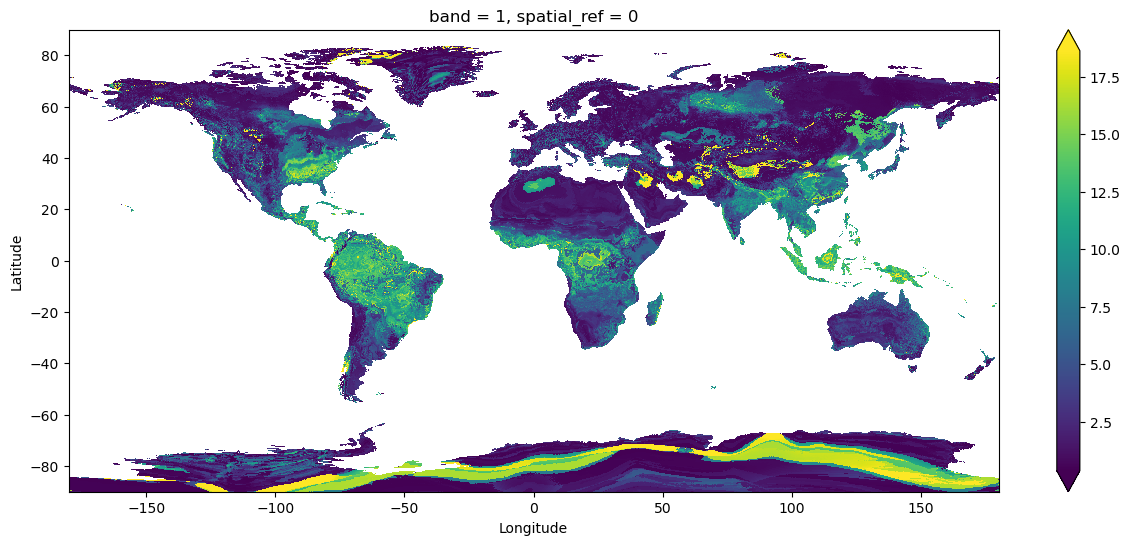

In [49]:
# create a plot of the predictions
plt.figure(figsize=(15, 6))
pred.plot(vmin=pred.quantile(0.01), vmax=pred.quantile(0.98))
xlabel = plt.xlabel('Longitude')
ylabel = plt.ylabel('Latitude')
plt.show

This global pattern seems reasonable (e.g. the tropics do have the highest tree heights). Ofcorse, there are some issues (e.g. at the south pole but we do not have data there anyway; see plot of sPlot distribution).

You may want to compare (visually) our map with the canopy height map of Nico Lang et al. 2023 (this data represents top of canopy height though, while we predict the average community height):
https://nlang.users.earthengine.app/view/global-canopy-height-2020

## Model comparison
We can also use a different model and assess the deviance between both models:

<function matplotlib.pyplot.show(close=None, block=None)>

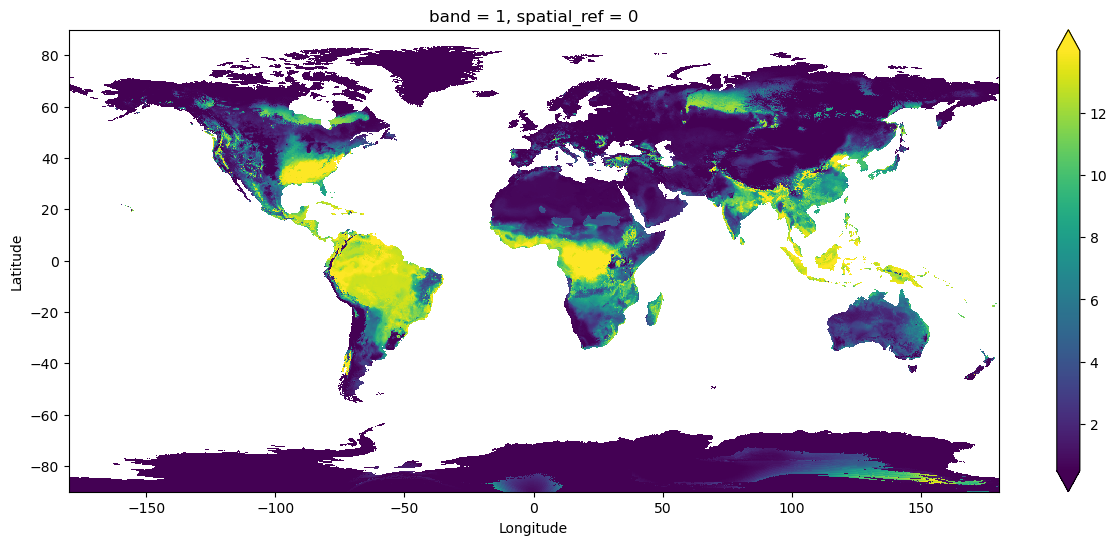

In [59]:
# run the XGBoost model on the entire data and write to the dummy raster
pred2 = worldclim[layer].copy()
pred2.values = predictor.predict(raster_data, model="NeuralNetTorch").values.reshape(pred2.shape)

# set the values to nan where the original raster had nan (the ML models will still predict something)
pred2.values[np.isnan(worldclim[layer].values)] = np.nan
#pred2.values = np.exp(pred2.values)

# create a plot of the predictions
plt.figure(figsize=(15, 6))
pred2.plot(vmin=pred.quantile(0.05), vmax=pred2.quantile(0.98))
xlabel = plt.xlabel('Longitude')
ylabel = plt.ylabel('Latitude')
plt.show

Plot the mismatch between both models

<function matplotlib.pyplot.show(close=None, block=None)>

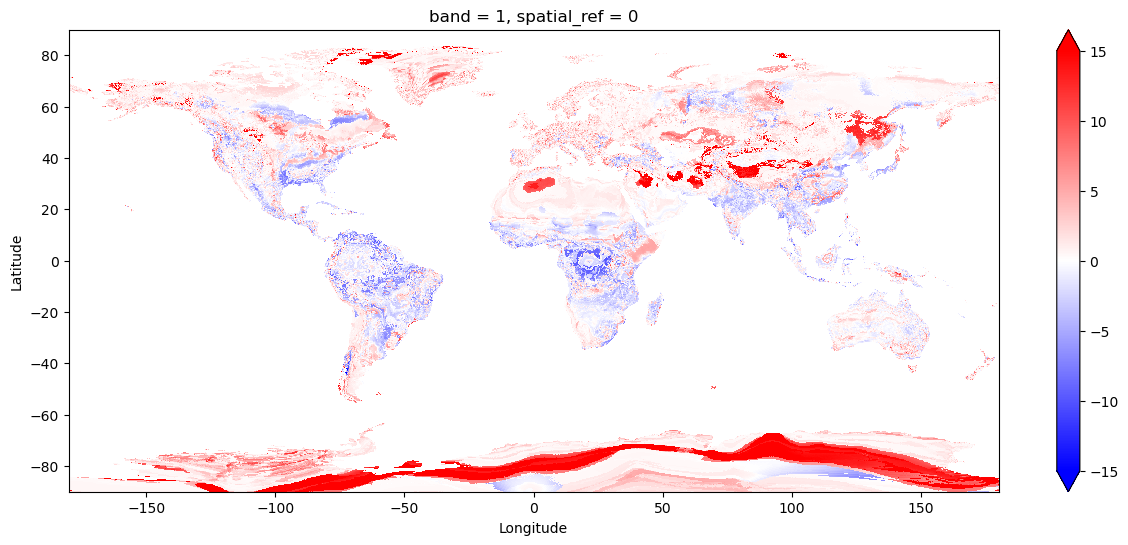

In [61]:
plt.figure(figsize=(15, 6))
(pred-pred2).plot(vmin=-15, vmax=15, cmap ='bwr')
xlabel = plt.xlabel('Longitude')
ylabel = plt.ylabel('Latitude')
plt.show